In [ ]:
import random
!pip install pymorphy2 nltk
import nltk
nltk.download("punkt")
nltk.download("stopwords")

In [ ]:
!pip install gensim

In [ ]:
import pylab
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import Image, display
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import pylab as pl
import re
import codecs
import nltk
from random import randint, choice
import pymorphy2
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

%pylab inline
pylab.rcParams['figure.figsize'] = (15,10)

# Задание 1
1. Проведите предобработку текстов из файлов positive.csv, negative.csv. Нужно выполнить те же действия, что в предыдущем дне, но не удалять редко встречающиеся слова. Регулировать использование редких слов будем на уровне модели word2vec. Не забудьте удалить стоп-слова.
2. Будем исследовать то, как влияют на качество преобразования *размер целевого векторного пространства* и *использование редких слов*. Создайте несколько моделей word2vec, перебрав параметры:
  - размер результирующего пространства: [10, 300, 500] при фиксированной минимальной встречаемости слов = 10
  - минимальная встречаемость слов: [1, 10, 100] при фиксированном размере результирующего векторного пространства = 300

  Обучите их на всем пространстве текстов.

3. Отберите 5 случайных слов из выборки позитивных публикаций и 5 случайных слови из выборки негативных публикаций.
4. Для каждой из обученных моделей найдите по 15 синонимов и по 15 антонимов для каждого из слов из п.3. Опишите:
  - как влияет размер результирующего пространства на точность определения синонимов/антонимов моделью? почему?
  - как влияет минимальная встречаемость слов на точность определения синонимов/антонимов моделью? почему?
5. Постройте графики распределения слов в двумерном пространстве. Опишите, как влияют исследуемые параметры на кучность и расположение точек на графике. Почему?
6. Возьмите любой твит, обучите модель word2vec с параметрами по умолчанию и попробуйте предсказать продолжение твита. Также попробуйте предсказать продолжение случайной фразы. Сравните результаты, полученные после обучения моделей с разным количеством эпох обучения.

Инициализируем 2 датафрейма:
df_pos - датафрейм с позитивными комментариями
df_neg - датафрейм с негативными комментариями

In [ ]:
df_pos = pd.read_csv('C:/Users/mm/Downloads/positive.csv', sep=';', header=None)
df_neg = pd.read_csv('C:/Users/mm/Downloads/negative.csv', sep=';', header=None)
df_pos[3][76563]

'@sk8forfood ога... 1 BTC = 925 USD тока хуй кто купит за такие деньги))'

Объединяем 2 датафрейма в 1 общий - df_tweets, после чего обнулим предыдущие

In [ ]:
df_tweets = pd.concat([df_pos, df_neg], ignore_index=True)
df_pos = pd.DataFrame(None)
df_neg = pd.DataFrame(None)

Зададим название для столбцов датафрейма, после чего в столбце positive изменим значения с -1 на 0

In [ ]:
df_tweets.columns = ['id', 'date', 'name', 'text', 'positive',
                     'rep', 'rtv', 'fav', 'total_count', 'fol', 'friends', 'list_count']
df_tweets.positive[df_tweets.positive==-1] = 0
df_tweets

,id,date,name,text,positive,rep,rtv,fav,total_count,fol,friends,list_count
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,0,0,0,0,1138,32,46,0
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,0,0,0,0,4822,38,32,0
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",0,0,0,1,165,13,16,0
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,0,1,0,2516,187,265,0


Далее проведем очистку данных с помощью функции ниже

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


morph = pymorphy2.MorphAnalyzer()


def text_preprocessing(text):
    """Функция принимает строку и возвращает список слов в начальной форме"""
    text = text.lower()                                                         # приводим текст к нижнему регистру
    text = re.sub(r"[^А-Яа-я]", " ", text)                                      # удаляем все некириллические символы
    words = word_tokenize(text)                                                 # разбиваем тексты на списки слов
    words = [morph.parse(word)[0].normal_form for word in words]                # приводим слова к начальной форме
    words = [word for word in words if word not in stopwords.words("russian")]  # удаляем слова из стоп-листа
    return words

In [ ]:
%%time
preprocessed_df = df_tweets[["text", "positive"]]
preprocessed_df.text = df_tweets.text.apply(text_preprocessing)

CPU times: total: 16min 44s
Wall time: 16min 44s


In [ ]:
preprocessed_df

,text,positive
0,"[школотый, поверь, самый, общество, профилиров...",1
1,"[всё, таки, немного, похожий, мальчик, всё, ра...",1
2,"[идиотка, испугаться]",1
3,"[угол, сидеть, погибать, голод, ещ, порция, вз...",1
4,"[значит, страшилка, блин, посмотреть, всё, час...",1
...,...,...
226829,"[каждый, хотеть, исправлять]",0
226830,"[скучать, вправлять, мозг, всё, равно, скучать]",0
226831,"[школа, говно, это, идти]",0
226832,"[тауриэль, грусть, обнять]",0


Приступим к разработке моделей word2vec с разными параметрами
Начнем с 3 моделей с разными размерами результирующего пространства: 10, 300 и 500 при фиксированной минимальной встречаемости слов = 10 (w2v_1, w2v_2, w2v_3)
После - создадим еще 3 модели с разной минимальной встречаемостью слов: 1, 10 и 100 при фиксированном размере результирующего пространства = 300 (w2v_4, w2v_5, w2v_6)

1я модель:

In [ ]:
from gensim.models import Word2Vec

w2v_1 = Word2Vec(vector_size=10, min_count=10)  # создадим экземпляр модели word2vec. Здесь size - размер векторного пространства,
                                       # min_count - минимальное количество появлений слова в наборе данных, при котором
                                       # будем учитывать это слово в модели
w2v_1.build_vocab(preprocessed_df.text)  # обучим модель на нашем наборе текстов

2я модель:

In [ ]:
w2v_2 = Word2Vec(vector_size=300, min_count=10)
w2v_2.build_vocab(preprocessed_df.text)

3я модель:

In [ ]:
w2v_3 = Word2Vec(vector_size=500, min_count=10)
w2v_3.build_vocab(preprocessed_df.text)

4я модель:

In [ ]:
w2v_4 = Word2Vec(vector_size=300, min_count=1)
w2v_4.build_vocab(preprocessed_df.text)

5я модель:

In [ ]:
w2v_5 = Word2Vec(vector_size=300, min_count=10)
w2v_5.build_vocab(preprocessed_df.text)

6я модель:

In [ ]:
w2v_6 = Word2Vec(vector_size=300, min_count=100)
w2v_6.build_vocab(preprocessed_df.text)

Отберем 5 случайных слов из негативных твитов

In [ ]:
neg_words = []
while len(neg_words) != 5:
    i = randint(0, len(preprocessed_df))
    if preprocessed_df['positive'][i] == 0:
        neg_words.append(random.choice(preprocessed_df['text'][i]))

neg_words

['ахах', 'всё', 'путин', 'вода', 'уснуть']

Отберем 5 случайных слов из положительных твитов

In [ ]:
pos_words = []
while len(pos_words) != 5:
    i = randint(0, len(preprocessed_df))
    if preprocessed_df['positive'][i] == 1:
        pos_words.append(random.choice(preprocessed_df['text'][i]))

pos_words

['танцевать', 'навальный', 'оно', 'тяжело', 'пенить']

Теперь для каждой из моделей найдем по 15 синонимов и 15 антонимов для каждого из слов, определенных выше

Для этого напишем функцию, которая принимает на вход 1 из 6 моделей, а также наш список слов из позитивного/негативного поста

In [ ]:
def synonyms_and_antonyms_report(model, words):
    i = 0
    clmns = list(np.repeat(words, 2))
    report = pd.DataFrame(columns=[clmns,['Синонимы', 'Антонимы'] * 5], index=[i for i in range(15)])
    for word in words:
        report[word, 'Синонимы'] = [i[0] for i in model.wv.most_similar(positive=[word], topn=15)]
        report[word, 'Антонимы'] = [i[0] for i in model.wv.most_similar(negative=[word], topn=15)]
    return report

Выведем 15 синонимов и антонимов к позитивным словам на основе 1го обучения w2v с параметрами vector_size=10, min_count=10


In [ ]:
synonyms_and_antonyms_report(w2v_1, pos_words)

танцевать                    навальный                           оно  \
      Синонимы     Антонимы        Синонимы        Антонимы      Синонимы   
0     трястись   снотворный         семечко          колесо          бакс   
1     гренобль    бляяяяять     калькулятор           верна        оочень   
2        герой        никак             ууж        домашний   эффективный   
3        слева      крестик     подставлять             шас           хач   
4   взрываться       однако        засыпать  распространить  исправляться   
5       лентяй       постер         жинхэнэ             бля         отпад   
6       форсаж   свихнуться         сдесить             чат  переделывать   
7      пуховик  итальянский             рис   откладываться         хогын   
8    опередить    маршрутка  грустьпечалить            соло        затечь   
9       поныть    огорчение         льстить       систереть      знакомый   
10         ийм    очевидный     потанцевать        заточить       саранск   
11     ипотека      москвич         возраст        набросок  похвастаться   
12       кавер       бабник           пушка     разыгрывать         алекс   
13  вылечиться     конспект             шип         силовик       шахматы   
14     зассать  растеряться             заш       кружиться         пудра   

                      тяжело                         пенить                
       Антонимы     Синонимы     Антонимы          Синонимы      Антонимы  
0       дохнуть      субтитр      грузить          мучиться      хочууууа  
1     репутация  беззаботный        треня            крошка         отряд  
2      тетрадка        каска  отправиться         банальный    мимимишный  
3           гос     спатенёк   приставать  поинтересоваться  неправильный  
4       пидорас      заорать     отложить         минусовый        завтро  
5           ээй          зов        плюха              биас         чудно  
6        костик  исполнитель        сытый         возбудить          кажа  
7          лихо       облить    отопление             пафос         гибдд  
8   преподавать    принцесса        конёк             пхахи        лапать  
9        тренек      энергия    избранный              сечь      радужный  
10   ирландский         маус        банда               тож       иваново  
11      кааааак   постепенно           хи         блестящий        мастер  
12          уеб       слэшер       маркет             бельё          весы  
13     выиграть       щедрый        класс          померить    объявление  
14         фара     почитать    порваться     заблокировать      беларусь

In [ ]:
synonyms_and_antonyms_report(w2v_1, neg_words)

ахах                       всё                   путин  \
           Синонимы     Антонимы     Синонимы     Антонимы   Синонимы   
0        обеспечить         подъ        побег     анатолий       стас   
1            адский       лечить      спороть      глянуть      дойти   
2              труд      аппетит       проход     задавать    рваться   
3              кекс     гармония        бровь          даж    улететь   
4            искать         рзло       справа    штормовой     кривая   
5         пятничный         окау       восток       пиздюк    западло   
6              небо       братан         утаа     отыграть    вскрыть   
7        заколебать      горячее         воот          дак    текущий   
8         россиянин        центр      светить  женственный     шлюшка   
9               кац    поправить     заложить        кевин  инспектор   
10         давление  действенный  сохраниться      краткий       мило   
11         исписать     сентябрь         рада       ангела    колечко   
12  самостоятельный   прозвучать         эссе          ужс       майк   
13              зло   незнакомка         мана       курица   погодить   
14     расслабиться  королевский    еврейский        соска    воронин   

                        вода                          уснуть                 
      Антонимы      Синонимы        Антонимы        Синонимы       Антонимы  
0         тажа    капельница          пинать          швеция     предстоять  
1   переходник        сходка        решиться          разбор        большой  
2       зевать       погнать         окатить  паранормальный     эшелоновец  
3      поржать      взрослый           ночий       возбудить    божественно  
4    пообещать     поражение          девуля        пожарить     отравиться  
5      скинуть   понедельник        бабулька        морозить         залить  
6    ахиренный        умница        форточка          мелочь          нихуй  
7       запара      загорать           ахпха        качаться             гу  
8         визг          утюг           режим              ве        пирсинг  
9       ноздря        богиня       благодаря         издавна       душевный  
10    попросту   наблюдаться             фил     музыкальный  недооценивать  
11        саша      наглость  распланировать      выкидывать  проигрыватель  
12          юм        чекина         такооий       претензия        понятно  
13   разложить      ковырять        конфетка        малёнька            був  
14    починить  практиковать              вщ          хийсэн         диджей

Выведем 15 синонимов и антонимов к позитивным словам на основе 2го обучения w2v с параметрами vector_size=300, min_count=10

In [ ]:
synonyms_and_antonyms_report(w2v_2, pos_words)

танцевать                               навальный                 \
      Синонимы       Антонимы                 Синонимы       Антонимы   
0     аквариум        капитан               упоминание           дико   
1       злодей           пить                  пятница           толь   
2          чип       брокколи                   ректор       краснеть   
3         юный    поверхность                 активист       заставка   
4      злиться     укладывать                      укр       покорить   
5   перечитать         алёнка                бляяяяять            ден   
6       сажать       классный                 отходить          еееий   
7        сосна      проверять                сплетница         ангина   
8          ура     распустить                   впадло    проигрывать   
9      пешеход         часами                     волк  волгоградский   
10       перёд          пилот                концепция       врядлить   
11  мимимишный        слушать                    хддда        насрать   
12     улетать            моб                  достать        драйвер   
13       ипать  проблематично  снаступающимтвиттерский      шерстяной   
14    госпасть       общаться                  сменить         задать   

            оно                     тяжело                         пенить  \
       Синонимы     Антонимы      Синонимы        Антонимы       Синонимы   
0          стоя       кидать        нибыть             укр          сапог   
1      взорвать    сработать  стремительно        насмерть        питание   
2           мяч          биз      таблетка       упороться        косичка   
3         понос    последнии        сервер          футбол          света   
4      аахахахи       чтоооо        оружие            дыра         основа   
5          баку           рв      петрович    позаботиться      племянник   
6           кул         айса           бум        романтик   основательно   
7       объятие          уоу        стайла       полегчать      тщательно   
8       находка   мандаринка     финальный         хурдать   обслуживание   
9        тесный  цивилизация      владимир            енот   наговаривать   
10  послезавтра          хаа      залечить         бассейн     показаться   
11      капуста     желанный         спеть  жизнерадостный  стихотворение   
12           ин     дааааааа         уууха          моффат         ванная   
13        болда          хны     священник         попугай         журфак   
14   отдаляться       хмурый         канон          баланс        дальний   

                
      Антонимы  
0       жёлтый  
1          ккк  
2      задание  
3       житься  
4      милашка  
5    предатель  
6         гель  
7           чс  
8    крутиться  
9      уровень  
10  подорожать  
11         бар  
12   стараться  
13          мм  
14       музей

In [ ]:
synonyms_and_antonyms_report(w2v_2, neg_words)

ахах                         всё                          путин  \
        Синонимы     Антонимы       Синонимы        Антонимы       Синонимы   
0          копия   огорчиться         малина        уточнить         шлюшка   
1             км  участвовать     травмпункт         редиска          чарли   
2     наполовину      кафедра   расслабиться          просто     предстоять   
3         яндекс     кладбище            бра         бооожий  подозрительно   
4          вишня       ранить         деметь          тряпка      подводить   
5         гитара      срочный  исключительно  предупреждение       старание   
6           айса        рубеж       выливать            окей          спеть   
7    физкультура         джей          фотик       наградить          пачим   
8        добавка      занятие     голосовать        простыня         похоже   
9          юрист     улыбочка     умудриться       простоять      допустить   
10         байхг  прискорбный      громкость            вряд        хайртая   
11  слабонервный          вых           мэтт          колено      потерпеть   
12           ева   электричка    прискорбный           ехууа         порция   
13   недостойный       впасть          карма          термин        верхний   
14        петров           нц        спутать        конечный       даваться   

                        вода                         уснуть            
       Антонимы     Синонимы         Антонимы      Синонимы  Антонимы  
0     актёрский      пиздить        проявлять     культурно    правда  
1     эскалатор  успокаивать             кома    количество    лекция  
2        любовь         село         лайковый         обувь  анжелика  
3      напиться    слушатель  останавливаться     президент      симс  
4          эээя     отвалить             борд      подумать     сахар  
5        нижний    развалить           фотать        дандаа    дохлый  
6         гээда     активный        концепция    мультфильм      ирка  
7        истина       кличка          логотип      кайфовый   расклад  
8     переспать   попадаться          сетевой        огород   бродить  
9          цена    ударяться          делишки  отваливаться   фиговый  
10        обида       трясти        проклятый       азазаза  вышивать  
11     запивать      душевно           задрот            ге  гирлянда  
12  приходиться    наградить           взгляд           эль      каре  
13         неий          нки            алмат       понятно       бол  
14      мобилка   рассуждать             всей  офигительный     киров

Выведем 15 синонимов и антонимов к позитивным словам на основе 3го обучения w2v с параметрами vector_size=500, min_count=10

In [ ]:
synonyms_and_antonyms_report(w2v_3, pos_words)

танцевать                    навальный                         оно  \
      Синонимы     Антонимы        Синонимы       Антонимы     Синонимы   
0       развод    пробивать         красный           чёрт   прикрывать   
1    кредитный         жечь        лайкнуть          жажда      фаворит   
2        архив   навалиться          щетина         тяжело  попробывать   
3         хаха      пробный         любимый     изобразить    переписка   
4          бен        нежно          матема       пиздатый         худо   
5       борьба        киров          слоган       кроватка       оттого   
6   отсутствие   измениться      недостаток     невероятно   издеваться   
7       худеть          вон          плиииз           гуля      срезать   
8     подавать  апокалипсис             жка       конченый          тян   
9      служить   признаться         заснять           окей         дима   
10    продавец      самолёт          наебал          финал          лес   
11   выключать   реанимация              що       морозный      фотошоп   
12       пнуть       можный        хахахахи  автоматически        сигна   
13    выбивать       выдать           темно        семинар        алесь   
14       налог         беда  предновогодний         сорить       мораль   

                     тяжело                            пенить                
       Антонимы    Синонимы          Антонимы        Синонимы      Антонимы  
0      дортмунд     слетать               нат             изя     подходить  
1   объявляться     тюльпан          спасиибо       открывать    охрененный  
2        разбор      побыть         навальный            чушь      контроль  
3       зоопарк        рост              вера        побухать  однообразный  
4       караоке    бедолага             слюна  интересоваться    забываться  
5       хардкор      гэтсби          противно          тожить      уступить  
6    викторович         поч      обыкновенный        грёбаный     подводить  
7      неловкий       долго          наоборот          предел       бетмена  
8            че      запрет  зарегистрировать           пачка       сгонять  
9    комплимент      фоткай           ёлочный           фирма       насморк  
10     евросоюз     анекдот            ижевск          прыщик       блокнот  
11    старинный        кинг             олимп            симс           зож  
12       молить  нереальный             попка           немец     недельный  
13        нитка         миг          вконтакт       кокосовый      коварный  
14   пропаганда    загрузка         категория            мммм    приятность

In [ ]:
synonyms_and_antonyms_report(w2v_3, neg_words)

ахах                       всё                          путин  \
       Синонимы    Антонимы      Синонимы           Антонимы    Синонимы   
0     позволить        девч        бургер                лад        луна   
1    спортивный        мыть  доминировать         откровенно    тульский   
2          кккк      родный           гмо        добавляться        утюг   
3           дош         аба        набить          избранный  задыхаться   
4      стрыкать        стас          стим          упомянуть     область   
5        налить       остро       тленный              падло   научиться   
6      изучение     интрига   стандартный              мятый    приёмный   
7          неть       ханна     вандализм          разогнать        эфир   
8        уснуть    интерьер          кино               ниит       забор   
9         альфа  наткнуться        фродый             фактор         крч   
10       ремонт       прина    добавиться  благотворительный      фууууа   
11    извинение      улитка     наполнить               гэта      карпов   
12    субботний    растение       продукт            плакать    обломать   
13     лайковый   развалить       глючить     паранормальный    малёнька   
14  захватывать     вызвать     закрыться                ваз    дараарай   

                            вода                        уснуть              
          Антонимы      Синонимы         Антонимы     Синонимы    Антонимы  
0           лекция       планета         стремный    потратить        рзло  
1            нитка        мадрид         натереть          гта    кержаков  
2             перл  нормаленький         целовать        сингл      кошмар  
3           миссия        огонёк  программировать  безразличие    параграф  
4       охрененный        струна            медик    старинный    смайлера  
5         положить    маршрутчик       продолжить   уникальный       танец  
6            изизя     встречать         частичка  употреблять         пик  
7             маяк         толпа              мрр   письменный    попилить  
8    расслабляться           йду     отваливаться      ледяной         соц  
9          сгореть         успех              дин        голос      камрад  
10     элементарно    выполнение         залечить         ахах   сдаваться  
11          бегать      гордость              лым       рыжеть     тренинг  
12  непередаваемый       люблюий         смоленск          лки       физик  
13          глобус           жик         вероника        уокер  прорваться  
14            флэш    заправлять           ноздря           ас      блиина

Выведем 15 синонимов и антонимов к позитивным словам на основе 4го обучения w2v с параметрами vector_size=300, min_count=1

In [ ]:
synonyms_and_antonyms_report(w2v_4, pos_words)

танцевать                         навальный                    \
         Синонимы         Антонимы         Синонимы          Антонимы   
0       раскокать       тоскаааааа           флюгер      эндокринолог   
1      побиюикать              шиш            жопуа       подлокотник   
2          упртст          елфимов       безмолвный            саксес   
3           жаман            этооо            азтая           ангарск   
4            лааа            малёк         флэйвить           дурочка   
5         халатик           агитка  мыпротивзубович     перевыполнять   
6    микроавтобус     конфигуратор              кик    заботливаятипо   
7        эмамдемс  учебаучебаучёба          додомок              чоуж   
8   аххахахааххах           турнир            вахуй          сынывоин   
9        памбасос          рендева        фоткиться              ткач   
10         аахахи     самосозженец         каулитец             кетан   
11  осуществяться      грязненький         сракотан              хост   
12          готов          нийгэма          напряга          скримера   
13       привееть    вспомнинаться            груть             почас   
14     забыыыыыть        убойность           люзира  волшебноемузнуть   

                                             оно                           \
                                        Синонимы                 Антонимы   
0                                          гыгыг                   заради   
1                                  щааааастьееий                 пассажыр   
2                                     аналогично                крючиться   
3                                         чирхэг                волнующий   
4                                        лактоза              ученический   
5                                       описание                       шь   
6                                    морозззззза                    нодар   
7                                             тк                 свендсон   
8                                            дог                котдивуар   
9   кокаиновыйсупвкойкенатертыйэбонитовойпалочка                   завтро   
10                                         тындс                    брюля   
11                                         жджая                 декольте   
12                                       транжир               баярлуулна   
13                                       здереть                покоцаный   
14                                      интеграл  авхазхзвахазхзвххазахха   

               тяжело                              пенить                    
             Синонимы        Антонимы            Синонимы          Антонимы  
0           симпотный  средактировать        обламываться   непринципиально  
1    урокихорошеготон        этожжуть  болеешьчувствовать  космооднокласник  
2               марто       зомбиящик               квант            ощение  
3              сельцо  преображенский          сортировка        бахархалта  
4         рееееевушко         юротдел             опухлоо          лидсский  
5         любопытство         ливнуть             орондоо            киллжа  
6   ахзхзпхзахзазхахз     развлекушка             стащить         поручение  
7           приветище       загнаться                ниго          хоккеист  
8                  шб      вперемешку             прихоть             сэдэв  
9            велошлем    анонсировать                 тка         тупенький  
10             ботаня      разблокать            кроссера      поскайпиться  
11             гонщик        брендинг       водопроводный       гополаипроф  
12           ссылошка         швырять   давноневиделиться              гаяр  
13            пилотаж       рукоделие              подний       арктический  
14                зад     потратиться      кооончилииться            снежка

In [ ]:
synonyms_and_antonyms_report(w2v_4, neg_words)

ахах                                  всё            \
      Синонимы                Антонимы     Синонимы  Антонимы   
0      говноед                 аъахахв       неттоп   вокруга   
1    ханжество               черлиденг      крахмал    анюков   
2      авдонин                коучинга  копирование   громада   
3      волкина              офицерский       заклад  бугульма   
4        мамыш             нервировать       номина   карнеги   
5        комар                   зраза     райотдел  астролог   
6     миргород                     фмб          ффф   бложега   
7     рузвельт                 балашов    ниасилили   тугодум   
8      матнуть                ааххаахи     насмарку        дл   
9      пыхалов  параскаведекатриафобия  начинаються   всюююий   
10         ряю              обострение       лентос      ланч   
11     сёлочка               поисковый        баден  снежанка   
12  твиттердаг        блядооднокласник        автоб    бамбей   
13      заново                недумать     вестарый      кбзд   
14    аахахахи             участвовать      валерий      ритц   

              путин                         вода                           \
           Синонимы     Антонимы        Синонимы                 Антонимы   
0      безрадостный      семеной  дааааааааааааа             пароооооооль   
1   гомосексуальный      галерея          абсурд                  альмета   
2         лососнуть       клуууб             ещй  ночноепожеланиеотананас   
3           джейзый      градусъ         уиллсон                  расдать   
4           сеъйчас         мысл     музыкальный                   бурять   
5           принтер       тудить        противно                   нейтан   
6         миниатюра    вскричать           свуга            апелляционный   
7            прасци     святковы      ааааааххха                 хозяюшка   
8       уходиииииия      прихлоп    наприглашать                портсигар   
9      батлуууууууа    каждорого       посягнуть                  стопсон   
10     прогрузиться        ласна          донухо             запитувалить   
11      ежесуточный  президентта            авик                   субкот   
12      ебланозарва       ярьсан       косвенный                  неладно   
13      лунопадение         дзюн              би              дэггуйтмээр   
14          сайлара        хамер        вскипеть                   бальша   

          уснуть              
        Синонимы    Антонимы  
0    беспонтовый     оройхон  
1       интервал   звеньевой  
2            ырд    дрифтить  
3   фрэнкиживить  перепройти  
4         бсынна      правда  
5   осторожность  отсутствие  
6         пустой  спонтанный  
7            укр  заиграться  
8     подаааарка   фосоессия  
9        вейсить      епаной  
10      исказить      сывать  
11          диск       ксеня  
12         нахир      божена  
13      подумать    набирать  
14           чну   галстучек

Выведем 15 синонимов и антонимов к позитивным словам на основе 5го обучения w2v с параметрами vector_size=300, min_count=10

In [ ]:
synonyms_and_antonyms_report(w2v_5, pos_words)

танцевать                               навальный                 \
      Синонимы       Антонимы                 Синонимы       Антонимы   
0     аквариум        капитан               упоминание           дико   
1       злодей           пить                  пятница           толь   
2          чип       брокколи                   ректор       краснеть   
3         юный    поверхность                 активист       заставка   
4      злиться     укладывать                      укр       покорить   
5   перечитать         алёнка                бляяяяять            ден   
6       сажать       классный                 отходить          еееий   
7        сосна      проверять                сплетница         ангина   
8          ура     распустить                   впадло    проигрывать   
9      пешеход         часами                     волк  волгоградский   
10       перёд          пилот                концепция       врядлить   
11  мимимишный        слушать                    хддда        насрать   
12     улетать            моб                  достать        драйвер   
13       ипать  проблематично  снаступающимтвиттерский      шерстяной   
14    госпасть       общаться                  сменить         задать   

            оно                     тяжело                         пенить  \
       Синонимы     Антонимы      Синонимы        Антонимы       Синонимы   
0          стоя       кидать        нибыть             укр          сапог   
1      взорвать    сработать  стремительно        насмерть        питание   
2           мяч          биз      таблетка       упороться        косичка   
3         понос    последнии        сервер          футбол          света   
4      аахахахи       чтоооо        оружие            дыра         основа   
5          баку           рв      петрович    позаботиться      племянник   
6           кул         айса           бум        романтик   основательно   
7       объятие          уоу        стайла       полегчать      тщательно   
8       находка   мандаринка     финальный         хурдать   обслуживание   
9        тесный  цивилизация      владимир            енот   наговаривать   
10  послезавтра          хаа      залечить         бассейн     показаться   
11      капуста     желанный         спеть  жизнерадостный  стихотворение   
12           ин     дааааааа         уууха          моффат         ванная   
13        болда          хны     священник         попугай         журфак   
14   отдаляться       хмурый         канон          баланс        дальний   

                
      Антонимы  
0       жёлтый  
1          ккк  
2      задание  
3       житься  
4      милашка  
5    предатель  
6         гель  
7           чс  
8    крутиться  
9      уровень  
10  подорожать  
11         бар  
12   стараться  
13          мм  
14       музей

In [ ]:
synonyms_and_antonyms_report(w2v_5, neg_words)

ахах                         всё                          путин  \
        Синонимы     Антонимы       Синонимы        Антонимы       Синонимы   
0          копия   огорчиться         малина        уточнить         шлюшка   
1             км  участвовать     травмпункт         редиска          чарли   
2     наполовину      кафедра   расслабиться          просто     предстоять   
3         яндекс     кладбище            бра         бооожий  подозрительно   
4          вишня       ранить         деметь          тряпка      подводить   
5         гитара      срочный  исключительно  предупреждение       старание   
6           айса        рубеж       выливать            окей          спеть   
7    физкультура         джей          фотик       наградить          пачим   
8        добавка      занятие     голосовать        простыня         похоже   
9          юрист     улыбочка     умудриться       простоять      допустить   
10         байхг  прискорбный      громкость            вряд        хайртая   
11  слабонервный          вых           мэтт          колено      потерпеть   
12           ева   электричка    прискорбный           ехууа         порция   
13   недостойный       впасть          карма          термин        верхний   
14        петров           нц        спутать        конечный       даваться   

                        вода                         уснуть            
       Антонимы     Синонимы         Антонимы      Синонимы  Антонимы  
0     актёрский      пиздить        проявлять     культурно    правда  
1     эскалатор  успокаивать             кома    количество    лекция  
2        любовь         село         лайковый         обувь  анжелика  
3      напиться    слушатель  останавливаться     президент      симс  
4          эээя     отвалить             борд      подумать     сахар  
5        нижний    развалить           фотать        дандаа    дохлый  
6         гээда     активный        концепция    мультфильм      ирка  
7        истина       кличка          логотип      кайфовый   расклад  
8     переспать   попадаться          сетевой        огород   бродить  
9          цена    ударяться          делишки  отваливаться   фиговый  
10        обида       трясти        проклятый       азазаза  вышивать  
11     запивать      душевно           задрот            ге  гирлянда  
12  приходиться    наградить           взгляд           эль      каре  
13         неий          нки            алмат       понятно       бол  
14      мобилка   рассуждать             всей  офигительный     киров

Выведем 15 синонимов и антонимов к позитивным словам на основе 6го обучения w2v с параметрами vector_size=300, min_count=100

In [ ]:
synonyms_and_antonyms_report(w2v_6, pos_words)

KeyError: "Key 'навальный' not present"

In [ ]:
synonyms_and_antonyms_report(w2v_6, neg_words)

ахах                     всё                   путин            \
          Синонимы    Антонимы    Синонимы    Антонимы    Синонимы  Антонимы   
0         традиция    родиться  голосовать      просто          юп    любовь   
1          зелёный   свободный        итак        кадр      похоже      цена   
2              чот        ясно    рождение         хех  досмотреть    гореть   
3          процесс      ладный       сопля        выше      вкусно       зуб   
4          планшет       дебил        пора         гиа         ала    привет   
5            актёр        кофе     главный        кожа   приезжать    гавный   
6   рождественский       время      стоять  измениться        счёт    сиська   
7         покушать      секрет         гэж  находиться     сюрприз    журнал   
8               др   обнимашка       пацан      важный     пожалуй    проект   
9              квн       лимит      блиина    поделать     полтора    съесть   
10       сообщение        жопа        боль    победить   отношение    выпуск   
11           диета    выиграть       класс        жена    добавить       дед   
12             сон        маша       хахах     весёлый   прочитать    выдать   
13          сильно         лка        поле  начинаться     влюбить    лежать   
14            матч  поздравить         хах     учиться    вечерний  операция   

              вода                    уснуть               
          Синонимы      Антонимы    Синонимы     Антонимы  
0          медведь         поиск      скидка         ахха  
1           власть    поговорить      пугать  волноваться  
2           начать     кончиться   виноватый     странный  
3             лишь      например    взломать       висеть  
4         читатель   оказываться    приятный          хуй  
5            канал  рассказывать          кр        режим  
6            ровно         менее    алкоголь     страница  
7          господь          пока  переживать        точно  
8   пересматривать            ди  подсказать     каникулы  
9             мера         режим     кричать      который  
10       компьютер   приходиться         ваш       никуда  
11            уйти       розовый        рада          топ  
12         считать       коллега      звезда    наступать  
13  выздоравливать           нах   отдохнуть     печалька  
14          ахахха       влюбить     странно      весёлый

## Вывод:
Какой вывод можно сделать из наших моделей с измененными параметрами понятно не очень. В любом из случаев она будет подбирать синонимы плохо, так как для такой задачи выборки словаря из твиттера крайне недостаточно.

Но на некоторых словах можно увидеть, что при увеличении передаваемых в w2v параметров, синонимы к некоторым словам выглядят более логичными. Особенно это прослеживается на слове 'путин'
в w2v_2, w2v_4 и w2v_5

Но на некоторых словах наблюдается обратная картина - качество синонимов и антонимов ухудшается

Построим графики для каждой из моделей

Для этого будем использовать функции ниже

In [ ]:
from sklearn.manifold import TSNE


def reduce_dimensions(w2v_model):
    """Фукнция принимает модель word2vec и возвращает массив абсцисс,
    массив ординат и массив слов после снижения размерности"""
    tsne = TSNE(n_components=2, random_state=256)  # создадим экземпляр модели TSNE
    vectors = np.asarray(w2v_model.wv.vectors)     # возьмем из модели 300-мерный массив слов-векторов
    labels = np.asarray(w2v_model.wv.index_to_key)   # отдельно сохраним соответствие номера вектора и самого слова
    vectors = tsne.fit_transform(vectors)          # проведем преобразование каждого вектора в 2-мерный

    x = [v[0] for v in vectors]                    # запишем отдельно массив абсцисс и массив ординат
    y = [v[1] for v in vectors]
    return x, y, labels


def plot_w2v(w2v_model):
    """Функция строит график распределения слов по векторному пространству
    размерности 2 исходя из обученной модели word2vec"""
    x, y, labels = reduce_dimensions(w2v_model)                      # получим значения по осям и названия точек (исходные слова)
    plt.scatter(x, y)                                                # строим график с точками
    words_to_show_indices = np.random.randint(len(labels), size=25)  # выберем 25 случайных слов, которые отобразим на графике
    for i in words_to_show_indices:
        plt.annotate(labels[i], (x[i], y[i]))                        # для каждого из этих 25 слов отобразим текст на картинке

график на основе 1го обучения w2v с параметрами vector_size=10, min_count=10

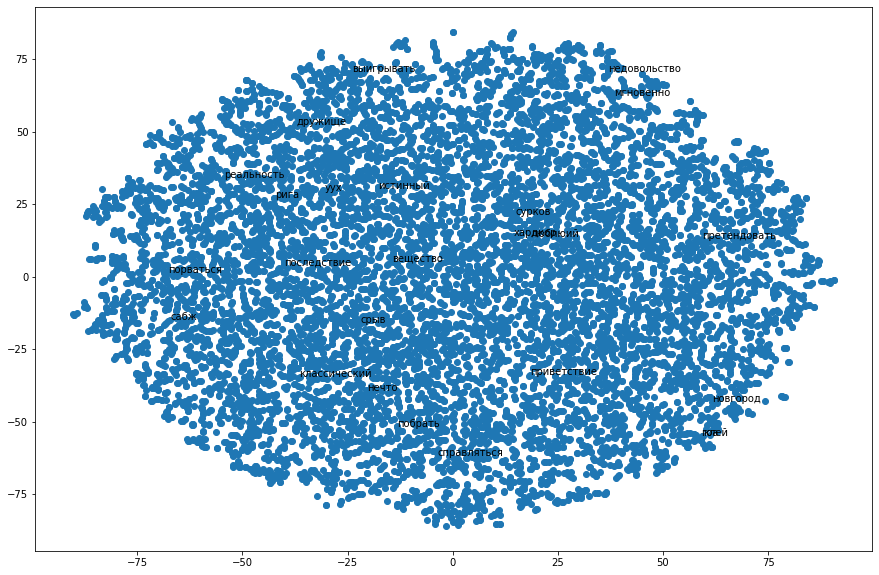

In [ ]:
plot_w2v(w2v_1)

график на основе 2го обучения w2v с параметрами vector_size=300, min_count=10

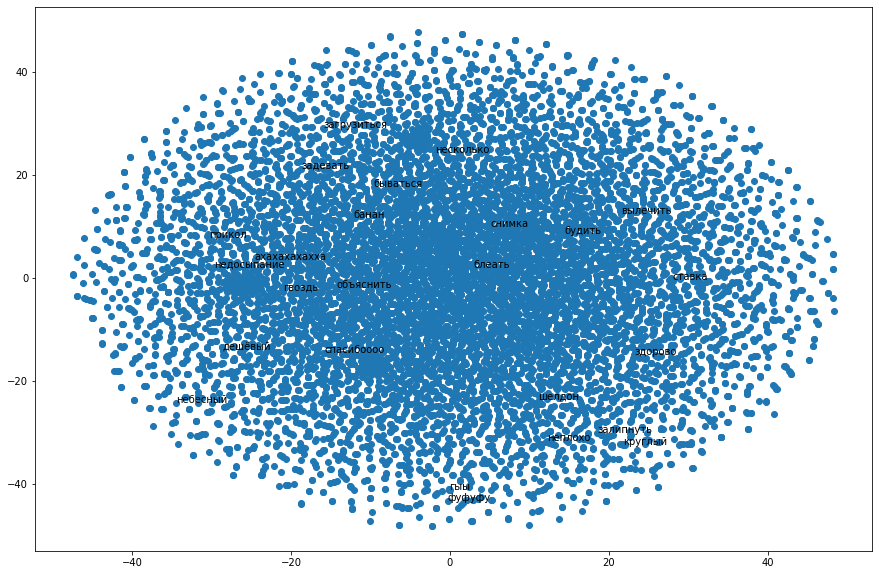

In [ ]:
plot_w2v(w2v_2)

график на основе 3го обучения w2v с параметрами vector_size=500, min_count=10

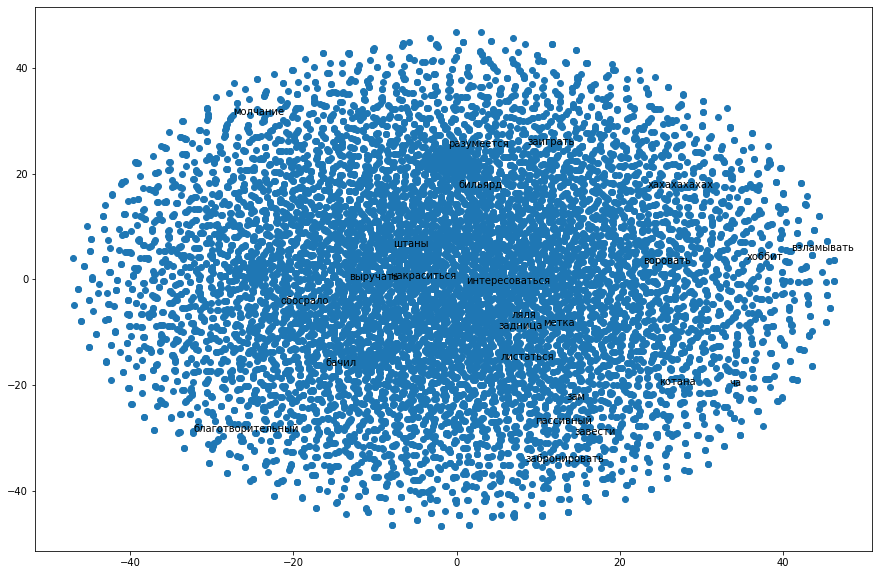

In [ ]:
plot_w2v(w2v_3)

график на основе 4го обучения w2v с параметрами vector_size=300, min_count=1

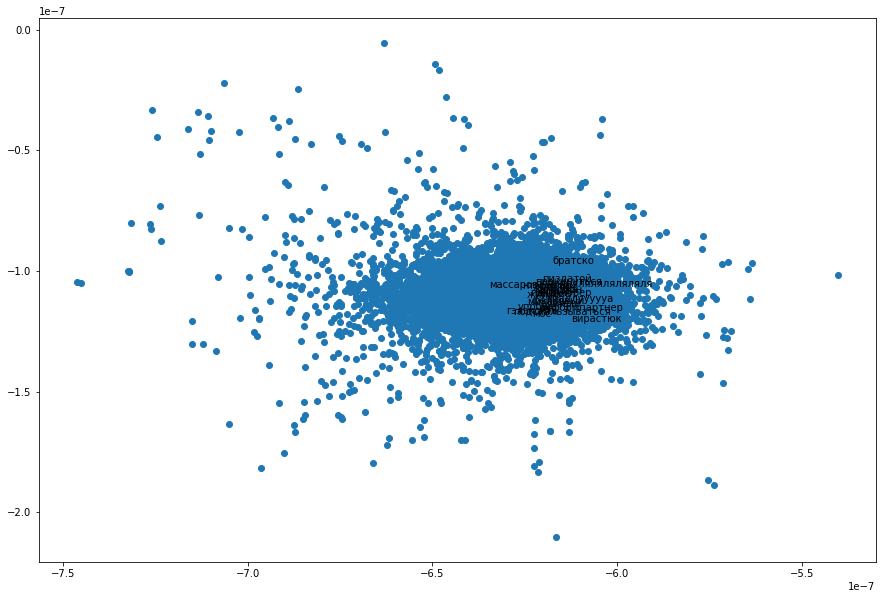

In [ ]:
plot_w2v(w2v_4)

график на основе 5го обучения w2v с параметрами vector_size=300, min_count=10

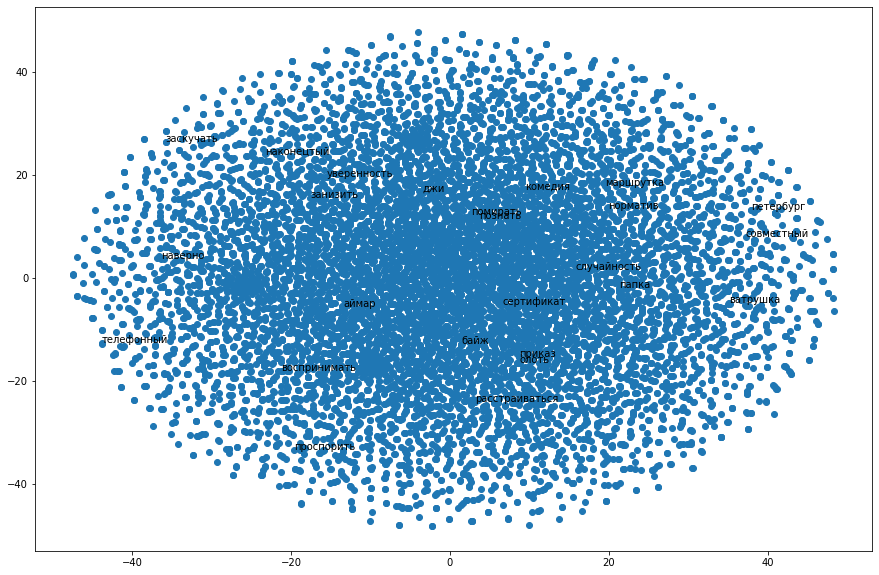

In [ ]:
plot_w2v(w2v_5)

график на основе 6го обучения w2v с параметрами vector_size=300, min_count=100

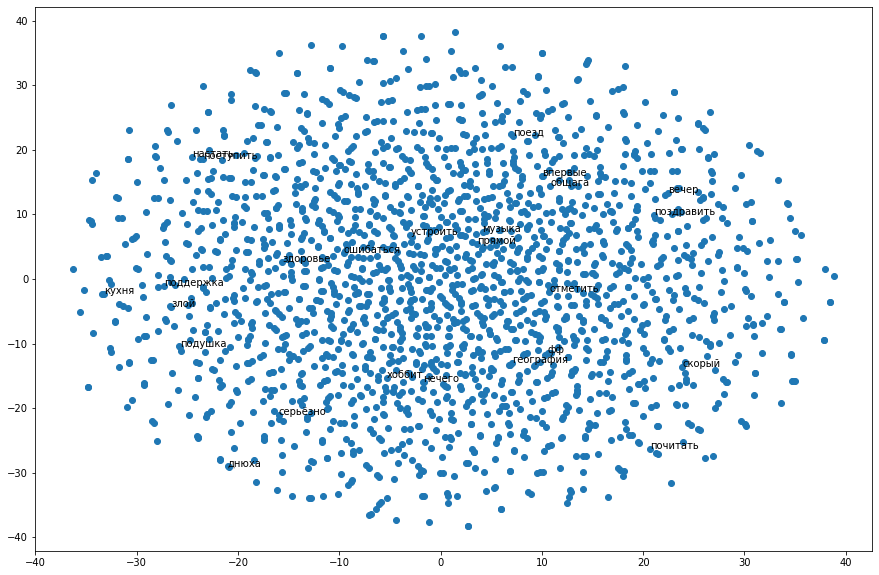

In [ ]:
plot_w2v(w2v_6)

Из графиков можно сделать вывод, что при увеличении параметра vector_size слова начинают располагаться лучше относительно друг друга (похожие слова ближе друг к другу, а не похожие - дальше).
В общем-то, логично, если мы выделяем для векторного пространства больше места

При увеличении параметра min_count видно, что очень много слов отсекается, благодаря чему оставшимся словам остается больше места в векторном пространстве (см. 1 и 3 графики)

# Задание 2

В этом задании от вас требуется провести классификацию текстов с использованием градиентного бустинга. Постройте такую модель, которая даст наилучший результат по метрике precision к классу 0, подобрав гиперпараметры:
- минимальная встречаемость слова в текстах в doc2vec
- максимальная глубина деревеьев в бустинге
- количество деревьев в бустинге

Дайте ответ на вопрос: лучше использовать более глубокие или более мелкие деревья в модели градиентного бустинга?

In [ ]:
%%time
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_df.text)]  # преобразуем наши тексты в объекты, понятные док-2-веку
d2v = Doc2Vec(tweets, min_count=2)                        # создадим модель Doc2Vec
d2v.train(tweets, total_examples=len(tweets), epochs=20)  # подберем веса коэффициентов внутри модели, которые больше будут подходить к нашему набору текстов

CPU times: total: 6min
Wall time: 4min 40s


In [ ]:
%%time
from sklearn.model_selection import train_test_split

# разобьем набор текстов на тренировочную и тестовую выборки
X_train_texts, X_test_texts, y_train, y_test = train_test_split(preprocessed_df.text, preprocessed_df.positive, test_size=0.25, random_state=21)

CPU times: total: 46.9 ms
Wall time: 46 ms


In [ ]:
%%time
def transform_text_array_to_vector_dataframe(text_array):
    """Функция, которая преобразует одномерную колонку списков слов из текстов
    в датафрейм со значениями векторов этих текстов"""
    columns = [str(n) for n in range(d2v.vector_size)]               # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(d2v.infer_vector).to_list()  # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)            # оборачиваем его в датафрейм для удобства


X_train = transform_text_array_to_vector_dataframe(X_train_texts)    # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

CPU times: total: 3min 1s
Wall time: 3min 1s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=10, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[03:06:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     27964
           1       0.63      0.63      0.63     28745

    accuracy                           0.62     56709
   macro avg       0.62      0.62      0.62     56709
weighted avg       0.62      0.62      0.62     56709

CPU times: total: 11min 32s
Wall time: 1min 29s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=80, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[03:08:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.61      0.62      0.61     27272
           1       0.64      0.63      0.63     29437

    accuracy                           0.62     56709
   macro avg       0.62      0.62      0.62     56709
weighted avg       0.62      0.62      0.62     56709

CPU times: total: 25min 40s
Wall time: 3min 21s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=200, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[03:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.61      0.62      0.61     27272
           1       0.64      0.63      0.63     29437

    accuracy                           0.62     56709
   macro avg       0.62      0.62      0.62     56709
weighted avg       0.62      0.62      0.62     56709

CPU times: total: 25min 31s
Wall time: 3min 17s


ниже попробовал увеличивать параметр n_estimators

увеличение глубины выше не улучшало результат. Напротиив, при глубине 10 он был самым лучшим

In [ ]:
%%time
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_df.text)]  # преобразуем наши тексты в объекты, понятные док-2-веку
d2v = Doc2Vec(tweets, min_count=10)                        # создадим модель Doc2Vec
d2v.train(tweets, total_examples=len(tweets), epochs=20)  # подберем веса коэффициентов внутри модели, которые больше будут подходить к нашему набору текстов

CPU times: total: 5min 38s
Wall time: 4min 33s


In [ ]:
%%time
from sklearn.model_selection import train_test_split

# разобьем набор текстов на тренировочную и тестовую выборки
X_train_texts, X_test_texts, y_train, y_test = train_test_split(preprocessed_df.text, preprocessed_df.positive, test_size=0.25, random_state=21)

CPU times: total: 31.2 ms
Wall time: 43 ms


In [ ]:
%%time
def transform_text_array_to_vector_dataframe(text_array):
    """Функция, которая преобразует одномерную колонку списков слов из текстов
    в датафрейм со значениями векторов этих текстов"""
    columns = [str(n) for n in range(d2v.vector_size)]               # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(d2v.infer_vector).to_list()  # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)            # оборачиваем его в датафрейм для удобства


X_train = transform_text_array_to_vector_dataframe(X_train_texts)    # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

CPU times: total: 2min 52s
Wall time: 2min 52s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=10, n_estimators=80)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[03:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     27768
           1       0.64      0.63      0.64     28941

    accuracy                           0.63     56709
   macro avg       0.63      0.63      0.63     56709
weighted avg       0.63      0.63      0.63     56709

CPU times: total: 18min 15s
Wall time: 2min 22s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=80, n_estimators=120)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[03:24:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.64      0.64     27280
           1       0.66      0.65      0.65     29429

    accuracy                           0.64     56709
   macro avg       0.64      0.64      0.64     56709
weighted avg       0.65      0.64      0.64     56709

CPU times: total: 59min 15s
Wall time: 8min 20s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=200, n_estimators=200)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[03:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     27361
           1       0.67      0.65      0.66     29348

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg       0.65      0.65      0.65     56709

CPU times: total: 1h 34min 32s
Wall time: 12min 48s


увеличил epochs и увеличил n_estimators, так как выше это улучшило результат

In [ ]:
%%time
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_df.text)]  # преобразуем наши тексты в объекты, понятные док-2-веку
d2v = Doc2Vec(tweets, min_count=2)                        # создадим модель Doc2Vec
d2v.train(tweets, total_examples=len(tweets), epochs=1500)  # подберем веса коэффициентов внутри модели, которые больше будут подходить к нашему набору текстов
%%time
from sklearn.model_selection import train_test_split

# разобьем набор текстов на тренировочную и тестовую выборки
X_train_texts, X_test_texts, y_train, y_test = train_test_split(preprocessed_df.text, preprocessed_df.positive, test_size=0.25, random_state=21)

UsageError: Line magic function `%%time` not found.


In [ ]:
%%time
def transform_text_array_to_vector_dataframe(text_array):
    """Функция, которая преобразует одномерную колонку списков слов из текстов
    в датафрейм со значениями векторов этих текстов"""
    columns = [str(n) for n in range(d2v.vector_size)]               # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(d2v.infer_vector).to_list()  # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)            # оборачиваем его в датафрейм для удобства


X_train = transform_text_array_to_vector_dataframe(X_train_texts)    # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

CPU times: total: 2h 59min 1s
Wall time: 2h 59min 3s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=40, n_estimators=80)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[10:39:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.62      0.64      0.63     27118
           1       0.66      0.64      0.65     29591

    accuracy                           0.64     56709
   macro avg       0.64      0.64      0.64     56709
weighted avg       0.64      0.64      0.64     56709

CPU times: total: 39min 18s
Wall time: 5min 4s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=40, n_estimators=160)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[10:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     27132
           1       0.67      0.65      0.66     29577

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg       0.65      0.65      0.65     56709

CPU times: total: 1h 15min 21s
Wall time: 9min 38s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=40, n_estimators=200)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[10:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     27166
           1       0.67      0.65      0.66     29543

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg       0.65      0.65      0.65     56709

CPU times: total: 1h 31min 51s
Wall time: 11min 41s


In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=100, n_estimators=200)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[11:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     27242
           1       0.67      0.65      0.66     29467

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg       0.65      0.65      0.65     56709

CPU times: total: 1h 33min 48s
Wall time: 12min


## Вывод:
Увеличение глубины деревьев не улучшило результат предсказания. Напротив, при наименьшей глубине деревьев показатель предсказания был наилучшим.
А вот увеличение количества дереьев (n_estimators) немного улучшило точность.
Так же в самом конце попробовал увеличить параметр epochs до 1500, но это тоже не улучшило результат предсказания

Лучший precision для класса 0 вышел 0.63